In [1]:
%load_ext autoreload
%autoreload 2

import click
import pickle
from tqdm import tqdm
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sbi.inference import FMPE
import os
from utils.data_generation import fetch_grid, sample_joint_distribution, sample_uniform_distribution
from utils.inference import preprocess_inputs, get_prior, get_eval_grid, get_posterior, compute_indicators_sampling_posterior, posterior_and_prior_kdeplot
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions
from lf2i.diagnostics.coverage_probability import compute_indicators_posterior

2024-12-18 09:31:46.550138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 09:31:46.550180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 09:31:46.551813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 09:31:46.558959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 09:31:47.911284: W tensorflow/compiler/tf2

In [2]:
FLOW_TYPE = 'npe'
B = 300_000  # num simulations to estimate posterior anid test statistics
B_PRIME = 100_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 30_000  # num simulations to estimate coverage probability
EVAL_GRID_SIZE = 50_000
DISPLAY_GRID_SIZE = 10 # irrelevant now that grid has been defined elsewhere
NORM_POSTERIOR_SAMPLES = None
CONFIDENCE_LEVEL = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

POI_DIM = 5
POIS = ['t_eff', 'logg', 'feh_surf', 'logl', 'dist']
LABELS = [r"$T_{eff}$ (K)",
            r"$\log g$ (cgs)",
            r"$[\text{Fe/H}]_{\text{surf}}$ (relative to solar)",
            r"$\log L$ ($L_{\odot}$)",
            r"$d$ (kpc)"]
PRIOR_SETTINGS = [2.0, 1.0, 0.0, -1.0, -2.0]
PRIOR_ARGS = {
    'lower_bound' : torch.tensor([2.5e3, 0.0, -4.0, -1.5, 0.0]),
    'upper_bound' : torch.tensor([1.5e4, 5.0, 0.5, 3.5, 1.0e3])
}
PLOT_PRIORS = False # These figures have already been generated

assets_dir = f'{os.getcwd()}/assets'
os.makedirs(assets_dir, exist_ok=True)
params, seds = fetch_grid(assets_dir=assets_dir) # POI grid + raw SEDs

# Figure 1.

## Priors

In [3]:
# Set up directories
prior_samples = []

for PRIOR_SETTING in PRIOR_SETTINGS:
    # Get prior
    try:
        with open(f'{assets_dir}/prior_{PRIOR_SETTING}.pkl', 'rb') as f:
            prior = pickle.load(f)
    except:
        theta, x = sample_joint_distribution(params=params,
                                            seds=seds,
                                            args={'age_feh_hyperparam': PRIOR_SETTING,},
                                            n_samples=B,
                                            assets_dir=assets_dir,)
        theta_p, x_p = preprocess_inputs(theta, x, ['t_eff', 'logg', 'feh_surf', 'logl', 'dist'])
        prior = get_prior(theta_p, prior_args=PRIOR_ARGS)
        with open(f'{assets_dir}/prior_{PRIOR_SETTING}.pkl', 'wb') as f:
            pickle.dump(prior, f)

    prior_samples.append(prior.sample((1_000,)))

In [4]:
import matplotlib.lines as lines

def plot_priors(
    ax,
    prior_samples,
    x_axis=LABELS[0],
    y_axis=LABELS[1],
    resolution=10,
    legend_outside=False,
    alphas=(0.3, 0.3,)
):
    # with plt.style.context(f"{assets_dir}/stylesheets/538-roboto.mplstyle"):
    # crab_trajectory = crs.get_source_trajectory("crab", -15)
    # crab_min_zenith = np.deg2rad(90 - np.array(crab_trajectory.alt).max())

    # mrk_trajectory = crs.get_source_trajectory("mrk421", -15)
    # mrk_min_zenith = np.deg2rad(90 - np.array(mrk_trajectory.alt).max())
    # levels = [0.0125, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8]
    levels = [0.05, 0.2, 0.4, 0.6, 0.8]

    colors=["#ca0020", "#0571b0"] # "#f4a582", "#f7f7f7", "#92c5de", "#0571b0"]

    # for j, split_id, differential_flux, min_zenith, color, alpha in zip(
    #     [0, 1, 2],
    #     [3, 3, 3], 
    #     [crs.differential_crab_flux, crs.differential_mrk421_flux, crs.differential_dm_flux],
    #     [crab_min_zenith, mrk_min_zenith, crab_min_zenith],
    #     colors,
    #     alphas
    # ):
    for idx, (color, alpha, sample_set) in enumerate(zip(colors, alphas, prior_samples)):
        # if j == 1 and skip_mrk:
        #     continue
        # split_df = filtered_manifest[(filtered_manifest["split"] == split_id) & (filtered_manifest["zenith"] >= min_zenith)].copy()
        # if precomputed_weighters[j] is None:
        #     weighter = te.SplitParameterWeights(
        #         unfiltered_manifest,
        #         split_df,
        #         differential_flux,
        #         resolution
        #     )
        #     precomputed_weighters[j] = weighter
        # else:
        #     weighter = precomputed_weighters[j]

        # split_df["weight"] = weighter.get_weight(split_df["log10_energy"], split_df["zenith"])
        # kde_df = split_df.sample(n=min(num_samples, len(split_df)), random_state=123)
        kde_df = pd.DataFrame(sample_set.numpy(), columns=LABELS)
        sns.kdeplot(
            y = kde_df[y_axis], 
            x = kde_df[x_axis], 
            # weights=split_df["weight"],
            ax = ax, 
            levels= levels, 
            alpha = alpha,
            color= color
        )

    ax.invert_xaxis()
    ax.invert_yaxis()

    handles = [lines.Line2D([0], [0], color=color) for color in colors]
    labels = ["1", "5"]
    # if legend_outside:
    #     legend = ax.legend(
    #         handles,
    #         labels,
    #         loc="upper center",  # Position legend relative to its bounding box
    #         bbox_to_anchor=(1.2, -0.1),  # Move outside the plot, below the lower-right corner
    #         frameon=False,  # Optional: remove the legend's frame
    #         ncol=3,         # Arrange items in a single row
    #     )
    # else:
    legend = ax.legend(handles, labels)

    # return legend
    return

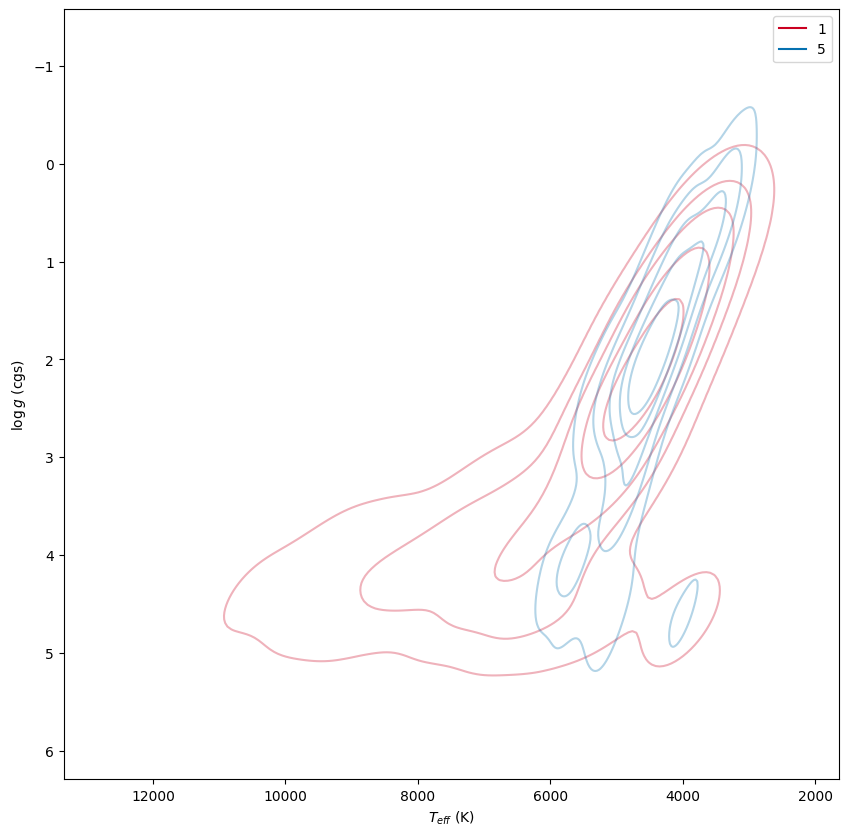

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_priors(ax, [prior_samples[0], prior_samples[4]])

## Boxplots

In [43]:
def coverage_boxplot(ax,
                     coverage_estimator,
                     prior_settings,
                     plot_title,
                     show_fliers=True,
                     axis_font_size=16,
                     title_font_size=20,
                     major_linewidth=2,
                     minor_linewidth=0.5):

    coverage_probs_for_setting = []

    for PRIOR_SETTING in PRIOR_SETTINGS:
        # Test set
        try:
            with open(f'{assets_dir}/tryout_set_{PRIOR_SETTING}.pkl', 'rb') as f:
                theta_t, x_t = pickle.load(f)
        except:
            raise ValueError('No test set available for this setting.')

        coverage_probs_for_setting.append(coverage_estimator.predict_proba(theta_t.numpy())[:, 1])
            

        xticks = [0, 1, 2, 3, 4]
        xlabels = ["1", "2", "3", "4", "5"]
        ax.set_xticks(xticks, labels=xlabels)

        sns.boxplot(np.vstack(coverage_probs_for_setting).T, color='gray', medianprops=dict(color='red'), boxprops=dict(alpha=0.5), showfliers=show_fliers, ax=ax)

        ax.axhline(0.9, color='black', linestyle='dashed', linewidth=minor_linewidth)
        ax.set_xlabel("Model", fontsize=axis_font_size)
        ax.set_ylabel("Coverage", fontsize=axis_font_size)
        ax.set_title(plot_title, fontsize=title_font_size)
        ax.set_ylim(-0.02, 1.02)

TBB Warning: The number of workers is currently limited to 11. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



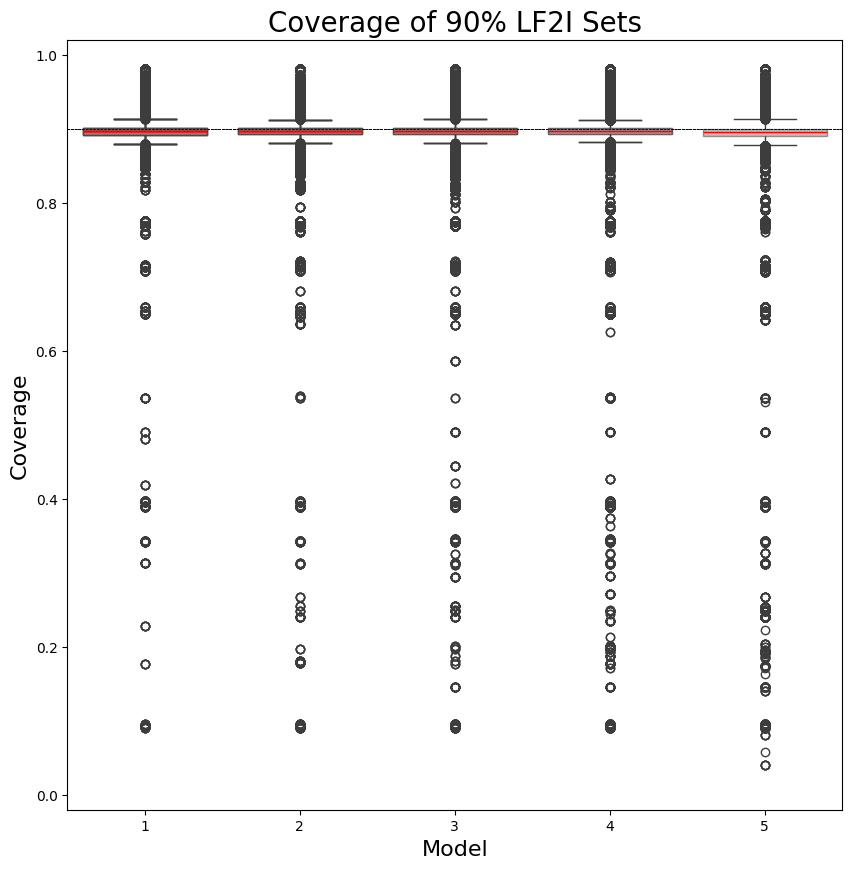

In [7]:
PRIOR_SETTING = 2.0
example_dir_for_setting = f'{os.getcwd()}/results/results_121624/example_{FLOW_TYPE}/setting_{PRIOR_SETTING}'
# os.makedirs(example_dir_for_setting, exist_ok=True)

try:
    with open(f'{example_dir_for_setting}/lf2i_diagnostics.pkl', 'rb') as f:
        diagnostics_estimator_lf2i, out_parameters, mean_proba, upper_proba, lower_proba = pickle.load(f)
except:
    raise ValueError('No diagnostics available for this setting.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
coverage_boxplot(ax, diagnostics_estimator_lf2i, PRIOR_SETTINGS, 'Coverage of 90% LF2I Sets')

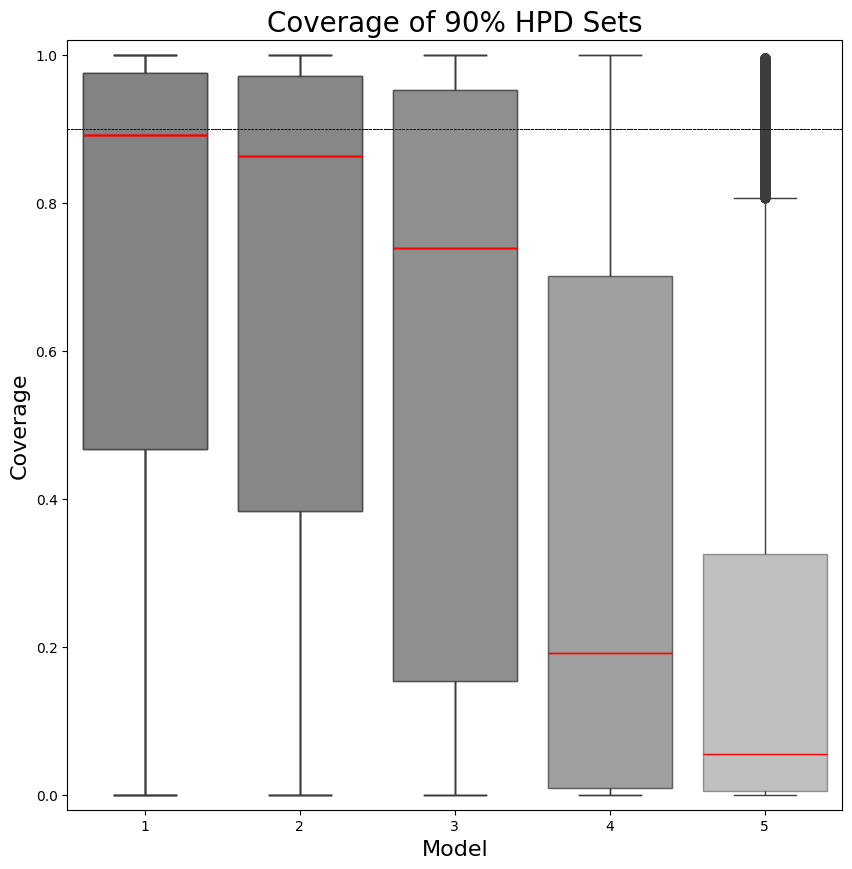

In [8]:
try:
    with open(f'{example_dir_for_setting}/hpd_diagnostics.pkl', 'rb') as f:
        diagnostics_estimator_hpd, out_parameters, mean_proba, upper_proba, lower_proba = pickle.load(f)
except:
    raise ValueError('No diagnostics available for this setting.')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
coverage_boxplot(ax, diagnostics_estimator_hpd, PRIOR_SETTINGS, 'Coverage of 90% HPD Sets')

## Diagnostic heatmaps

In [9]:
def plot_pointwise_coverage(
    fig,
    grid_spec,
    hpd_coverage_estimator,
    lf2i_coverage_estimator,
    axis_font_size=16,
    title_font_size=20
):

    cmap = plt.cm.inferno
    cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the colormap

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    min_color = 2.5
    bounds = np.linspace(min_color+7.5, 100, 13)
    bounds = [2.5] + list(bounds)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    grid_resolution = 70
    margin = 0.01

    with open(f'{assets_dir}/tryout_diagnostics_set.pkl', 'rb') as f:
        plot_param_grid, x_g = pickle.load(f)
    
    hpd_coverage_probs = hpd_coverage_estimator.predict_proba(plot_param_grid.numpy())[:, 1]
    lf2i_coverage_probs = lf2i_coverage_estimator.predict_proba(plot_param_grid.numpy())[:, 1]
    theta_diag_df = pd.DataFrame(plot_param_grid.numpy(), columns=LABELS)

    for ax_i, fixed_dim_index, non_fixed_dim_indexes, axis_labels in zip(
        [0, 1, 2],
        [2, 1, 0],
        [[0, 1], [2, 0], [2, 1]],
        [[LABELS[0], LABELS[1]], [LABELS[2], LABELS[0]], [LABELS[2], LABELS[1]]],
    ):
        ax = fig.add_subplot(grid_spec[0, ax_i])
        x_bins = np.histogram_bin_edges(theta_diag_df[axis_labels[0]], bins='auto')
        y_bins = np.histogram_bin_edges(theta_diag_df[axis_labels[1]], bins='auto')
        binned_sum_proba, xedges, yedges = np.histogram2d(theta_diag_df[axis_labels[0]], theta_diag_df[axis_labels[1]], bins=[x_bins, y_bins], weights=np.round(hpd_coverage_probs*100, 2))
        bin_counts, xedges, yedges = np.histogram2d(theta_diag_df[axis_labels[0]], theta_diag_df[axis_labels[1]], bins=[x_bins, y_bins])
        heatmap_values = binned_sum_proba / bin_counts
        heatmap = ax.imshow(heatmap_values.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', norm=norm, cmap=cmap)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_xlabel(axis_labels[0], fontsize=axis_font_size)
        ax.set_ylabel(axis_labels[1], fontsize=axis_font_size)
        # ax.set_xlim(config.eval_param_mins[non_fixed_dim_indexes[0]].item(), config.eval_param_maxes[non_fixed_dim_indexes[0]].item())
        # ax.set_ylim(config.eval_param_mins[non_fixed_dim_indexes[1]].item(), config.eval_param_maxes[non_fixed_dim_indexes[1]].item())
        
        if ax_i == 1:
            ax.set_title("Coverage Diagnostics: 90% HPD Credible Regions", fontsize=title_font_size)

        ax = fig.add_subplot(grid_spec[1, ax_i])
        binned_sum_proba, xedges, yedges = np.histogram2d(theta_diag_df[axis_labels[0]], theta_diag_df[axis_labels[1]], bins=[x_bins, y_bins], weights=np.round(lf2i_coverage_probs*100, 2))
        bin_counts, xedges, yedges = np.histogram2d(theta_diag_df[axis_labels[0]], theta_diag_df[axis_labels[1]], bins=[x_bins, y_bins])
        heatmap_values = binned_sum_proba / bin_counts
        heatmap = ax.imshow(heatmap_values.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', norm=norm, cmap=cmap)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_xlabel(axis_labels[0], fontsize=axis_font_size)
        ax.set_ylabel(axis_labels[1], fontsize=axis_font_size)
        # ax.set_xlim(config.eval_param_mins[non_fixed_dim_indexes[0]].item(), config.eval_param_maxes[non_fixed_dim_indexes[0]].item())
        # ax.set_ylim(config.eval_param_mins[non_fixed_dim_indexes[1]].item(), config.eval_param_maxes[non_fixed_dim_indexes[1]].item())
        
        if ax_i == 1:
            ax.set_title("Coverage Diagnostics: 90% LF2I Confidence Sets", fontsize=title_font_size)


    # Add a single colorbar for all subplots to the right of the figure
    cbar_ax = fig.add_subplot(grid_spec[:, 3])  # Grid location: rows 2 and 3, last column
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax, format='%1.2f', ticks=bounds, boundaries=bounds
    )
    
    # Format colorbar ticks and labels
    ticks = [r"$\leq$" + str(label) + "%" if label == min_color else str(label) + "%" for label in bounds]
    cbar.ax.yaxis.set_ticklabels(ticks)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.yaxis.label.set_size(30)
    cbar.ax.set_ylabel("Estimated Coverage", fontsize=20)

## Putting them together

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

def plot_paper_figure_1(
    hpd_coverage_estimator,
    lf2i_coverage_estimator,
    show_fliers=False,
    axis_font_size=16,
    title_font_size=20
):
    # with plt.style.context("stylesheets/538-roboto-nogrid.mplstyle"):
    fig = plt.figure(figsize=(15, 9))
    # fig.suptitle("Panel A: Global Coverage Analysis", fontweight="bold", fontsize=24)

    top_level_gridspec = gridspec.GridSpec(3, 1, figure=fig, height_ratios=[1, 0.5, 2])

    top_subgridspec = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=top_level_gridspec[0])

    ax1 = fig.add_subplot(top_subgridspec[0])
    ax2 = fig.add_subplot(top_subgridspec[1])
    ax3 = fig.add_subplot(top_subgridspec[2])

    div_line = 0.638
    
    fig.add_artist(patches.Rectangle(
        (0, div_line),          # Lower-left corner in figure coordinates
        1, 1-div_line,            # Width and height in figure coordinates (normalized)
        transform=fig.transFigure,  # Use figure coordinates
        edgecolor="darkgray",
        linewidth=2,
        facecolor="gainsboro",
        zorder=0  # Place the rectangle behind everything
    ))
    
    fig.add_artist(patches.Rectangle(
        (0, 0),          # Lower-left corner in figure coordinates
        1, div_line - 0.015,            # Width and height in figure coordinates (normalized)
        transform=fig.transFigure,  # Use figure coordinates
        edgecolor="darkgray",
        linewidth=2,
        facecolor="gainsboro",
        zorder=0  # Place the rectangle behind everything
    ))


    # the following syntax does the same as the GridSpecFromSubplotSpec call above:
    bottom_subgridspec = gridspec.GridSpecFromSubplotSpec(2, 5, subplot_spec=top_level_gridspec[2], width_ratios=[1, 1, 1, 0.1, 0.2], height_ratios=[1, 1], hspace=0.45, wspace=0.3)


    # plot_priors(ax1, unfiltered_manifest, filtered_manifest, precomputed_weighters, False, "log10_energy", "zenith", 10_000, 10, alphas=[0.8, 0.8, 0.3])
    plot_priors(ax1, [prior_samples[0], prior_samples[4]])

    ax1.set_ylabel(LABELS[1], fontsize=axis_font_size)
    ax1.set_xlabel(LABELS[0], fontsize=axis_font_size)
    # ax1.set_xlim(config.eval_param_mins[0], config.eval_param_maxes[0])
    # ax1.set_ylim(config.eval_param_mins[1], config.eval_param_maxes[1])
    ax1.set_title("Galactic Model", fontsize=title_font_size)

    # for true_obs, true_color in zip([test_ds[high_prior_density_obs_id], test_ds[low_prior_Density_obs_id]], ["blue", "red"]):
    #     truth_slice = true_obs["params"].cpu().numpy()[:2]
    #     ax1.scatter(x=truth_slice[0], y=truth_slice[1], alpha=1, color=true_color, marker="*", s=250, zorder=10)
    #     ax1.axvline(true_obs["params"][0].item(), color=true_color, linestyle="dashed")
    #     ax1.axhline(true_obs["params"][1].item(), color=true_color, linestyle="dashed")

    # coverage_boxplot(
    #     config,
    #     ax2,
    #     hpd_coverage_estimator,
    #     precomputed_weighters,
    #     hpd_param_values,
    #     joint_hpd_hits,
    #     "Coverage of 90% Credible Regions (HPD)",
    #     axis_font_size=axis_font_size,
    #     title_font_size=title_font_size
    # )
    coverage_boxplot(ax2, lf2i_coverage_estimator, PRIOR_SETTINGS, 'Coverage of 90% LF2I Sets', show_fliers=show_fliers)

    # coverage_boxplot(
    #     config,
    #     ax3,
    #     lf2i_coverage_estimator,
    #     precomputed_weighters,
    #     lf2i_param_values,
    #     joint_lf2i_hits,
    #     "Coverage of 90% Confidence Sets (LF2I)",
    #     axis_font_size=axis_font_size,
    #     title_font_size=title_font_size
    # )
    coverage_boxplot(ax3, hpd_coverage_estimator, PRIOR_SETTINGS, 'Coverage of 90% HPD Sets', show_fliers=show_fliers)

    # plot_pointwise_coverage(
    #     config,
    #     fig,
    #     bottom_subgridspec,
    #     hpd_coverage_estimator,
    #     lf2i_coverage_estimator,
    #     axis_font_size=axis_font_size,
    #     title_font_size=title_font_size
    # )
    plot_pointwise_coverage(
        fig=fig,
        grid_spec=bottom_subgridspec,
        hpd_coverage_estimator=hpd_coverage_estimator,
        lf2i_coverage_estimator=lf2i_coverage_estimator,
        axis_font_size=16,
        title_font_size=20
    )
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.0)

    return fig

/tmp/user/3391/ipykernel_2161590/2194711582.py:70: RuntimeWarning: invalid value encountered in divide
  heatmap_values = binned_sum_proba / bin_counts
/tmp/user/3391/ipykernel_2161590/2194711582.py:85: RuntimeWarning: invalid value encountered in divide
  heatmap_values = binned_sum_proba / bin_counts


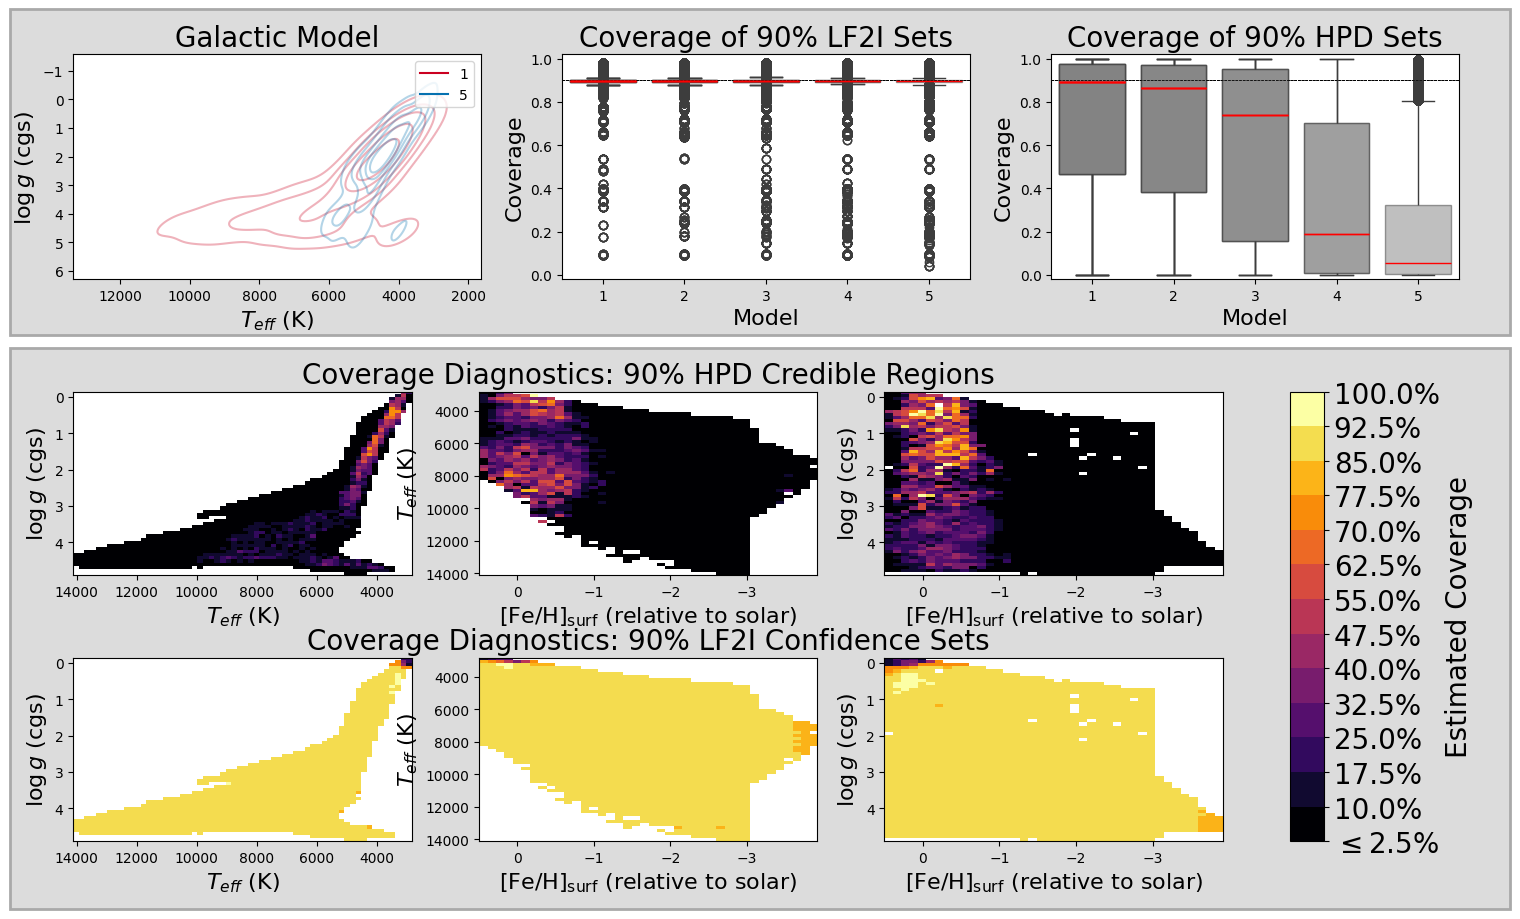

In [45]:
fig = plot_paper_figure_1(
    hpd_coverage_estimator=diagnostics_estimator_hpd,
    lf2i_coverage_estimator=diagnostics_estimator_lf2i,
    show_fliers=True,
    axis_font_size=16,
    title_font_size=20
)
fig.savefig(f'{example_dir_for_setting}/paper_figure_1.png', dpi=500)

/tmp/user/3391/ipykernel_2161590/2194711582.py:70: RuntimeWarning: invalid value encountered in divide
  heatmap_values = binned_sum_proba / bin_counts
/tmp/user/3391/ipykernel_2161590/2194711582.py:85: RuntimeWarning: invalid value encountered in divide
  heatmap_values = binned_sum_proba / bin_counts


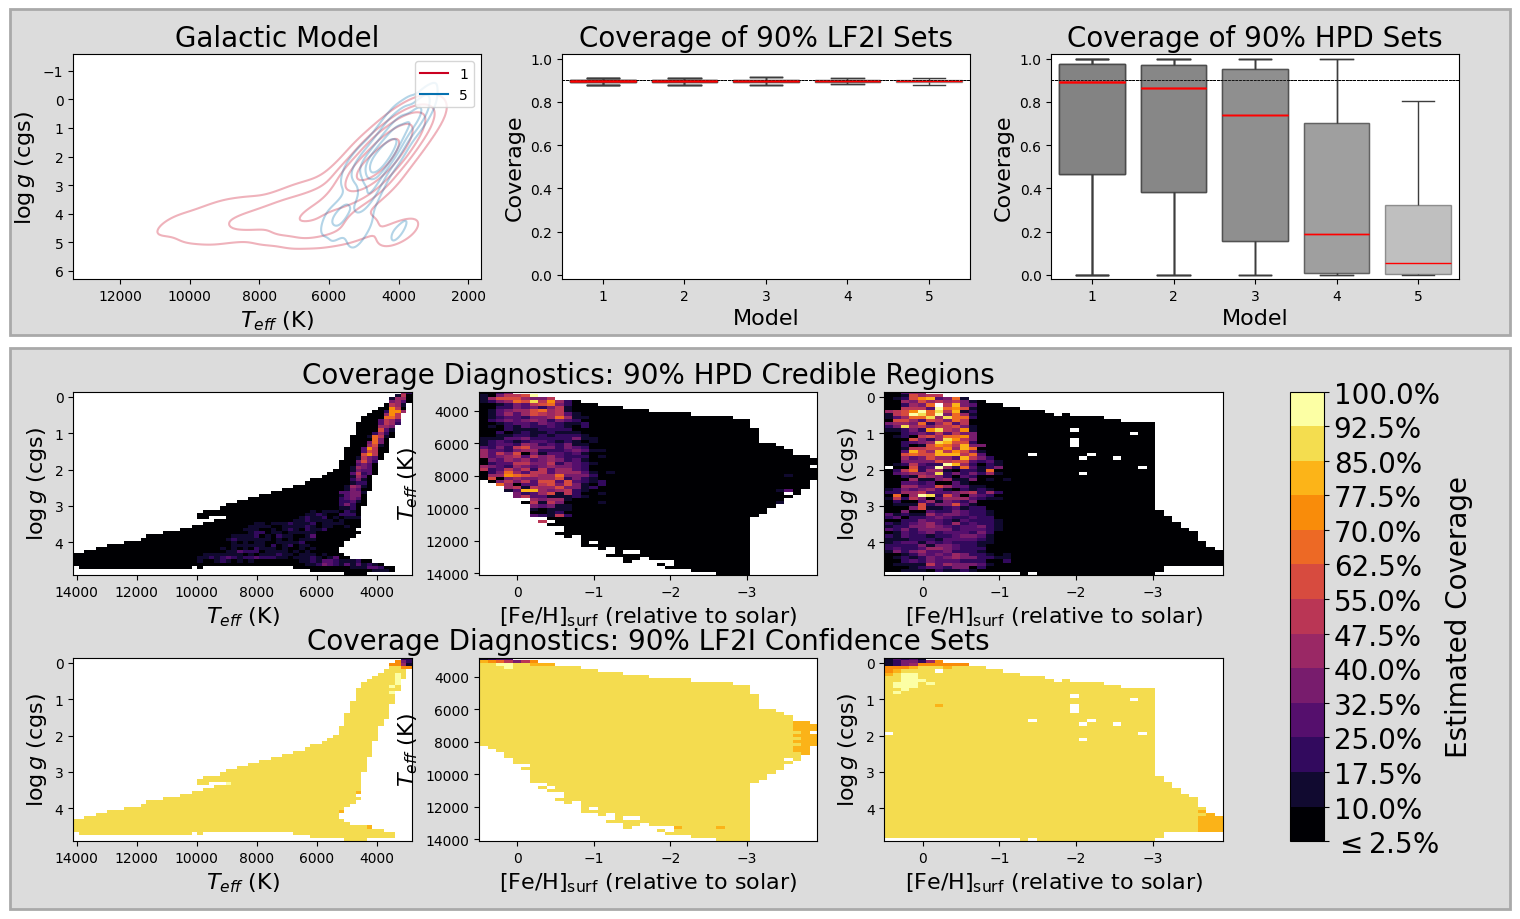

In [46]:
fig = plot_paper_figure_1(
    hpd_coverage_estimator=diagnostics_estimator_hpd,
    lf2i_coverage_estimator=diagnostics_estimator_lf2i,
    show_fliers=False,
    axis_font_size=16,
    title_font_size=20
)
fig.savefig(f'{example_dir_for_setting}/paper_figure_1_no_fliers.png', dpi=500)

## 2x2 diagnostics coverage for completeness

In [39]:
def plot_pointwise_coverage_full(
    coverage_estimator,
    title="Coverage Diagnostics: 90% HPD Credible Regions",
    axis_font_size=16,
    title_font_size=20
):

    cmap = plt.cm.inferno
    cmaplist = [cmap(i) for i in range(cmap.N)] # extract all colors from the colormap

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    min_color = 2.5
    bounds = np.linspace(min_color+7.5, 100, 13)
    bounds = [2.5] + list(bounds)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    grid_resolution = 70
    margin = 0.01

    with open(f'{assets_dir}/tryout_diagnostics_set.pkl', 'rb') as f:
        plot_param_grid, x_g = pickle.load(f)
    
    coverage_probs = coverage_estimator.predict_proba(plot_param_grid.numpy())[:, 1]
    theta_diag_df = pd.DataFrame(plot_param_grid.numpy(), columns=LABELS)
    fig, axs = plt.subplots(5, 5, figsize=(30, 30))

    for non_fixed_dim_indexes, axis_labels in zip(
        [[j, i] for i in range(POI_DIM-1) for j in range(i+1, POI_DIM)],
        [[LABELS[i], LABELS[j]] for i in range(POI_DIM-1) for j in range(i+1, POI_DIM)],
    ):
        # ax = fig.add_subplot(grid_spec[0, ax_i])
        ax = axs[non_fixed_dim_indexes[0], non_fixed_dim_indexes[1]]
        x_bins = np.histogram_bin_edges(theta_diag_df[axis_labels[0]], bins='auto')
        y_bins = np.histogram_bin_edges(theta_diag_df[axis_labels[1]], bins='auto')
        binned_sum_proba, xedges, yedges = np.histogram2d(theta_diag_df[axis_labels[0]], theta_diag_df[axis_labels[1]], bins=[x_bins, y_bins], weights=np.round(coverage_probs*100, 2))
        bin_counts, xedges, yedges = np.histogram2d(theta_diag_df[axis_labels[0]], theta_diag_df[axis_labels[1]], bins=[x_bins, y_bins])
        heatmap_values = binned_sum_proba / bin_counts
        heatmap = ax.imshow(heatmap_values.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', norm=norm, cmap=cmap)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_xlabel(axis_labels[0], fontsize=axis_font_size)
        ax.set_ylabel(axis_labels[1], fontsize=axis_font_size)
        # ax.set_xlim(config.eval_param_mins[non_fixed_dim_indexes[0]].item(), config.eval_param_maxes[non_fixed_dim_indexes[0]].item())
        # ax.set_ylim(config.eval_param_mins[non_fixed_dim_indexes[1]].item(), config.eval_param_maxes[non_fixed_dim_indexes[1]].item())
        
        # if ax_i == 1:
        #     ax.set_title("Coverage Diagnostics: 90% HPD Credible Regions", fontsize=title_font_size)

        # ax = fig.add_subplot(grid_spec[1, ax_i])
        # binned_sum_proba, xedges, yedges = np.histogram2d(theta_diag_df[axis_labels[0]], theta_diag_df[axis_labels[1]], bins=[x_bins, y_bins], weights=np.round(lf2i_coverage_probs*100, 2))
        # bin_counts, xedges, yedges = np.histogram2d(theta_diag_df[axis_labels[0]], theta_diag_df[axis_labels[1]], bins=[x_bins, y_bins])
        # heatmap_values = binned_sum_proba / bin_counts
        # heatmap = ax.imshow(heatmap_values.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', norm=norm, cmap=cmap)
        # ax.invert_xaxis()
        # ax.invert_yaxis()
        # ax.set_xlabel(axis_labels[0], fontsize=axis_font_size)
        # ax.set_ylabel(axis_labels[1], fontsize=axis_font_size)
        # # ax.set_xlim(config.eval_param_mins[non_fixed_dim_indexes[0]].item(), config.eval_param_maxes[non_fixed_dim_indexes[0]].item())
        # # ax.set_ylim(config.eval_param_mins[non_fixed_dim_indexes[1]].item(), config.eval_param_maxes[non_fixed_dim_indexes[1]].item())
        
        # if ax_i == 1:
        #     ax.set_title("Coverage Diagnostics: 90% LF2I Confidence Sets", fontsize=title_font_size)

    for i in range(5):
        for j in range(5):
            if i >= j:
                axs[j, i].axis('off')
                continue


    # Add a single colorbar for all subplots to the right of the figure
    # cbar_ax = fig.add_subplot(grid_spec[:, 3])  # Grid location: rows 2 and 3, last column
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[-1, -1],
        format='%1.2f', ticks=bounds, boundaries=bounds
    )
    
    # Format colorbar ticks and labels
    ticks = [r"$\leq$" + str(label) + "%" if label == min_color else str(label) + "%" for label in bounds]
    cbar.ax.yaxis.set_ticklabels(ticks)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.yaxis.label.set_size(30)
    cbar.ax.set_ylabel("Estimated Coverage", fontsize=20)
    plt.suptitle(title, fontsize=title_font_size)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

/tmp/user/3391/ipykernel_2161590/3421426924.py:40: RuntimeWarning: invalid value encountered in divide
  heatmap_values = binned_sum_proba / bin_counts


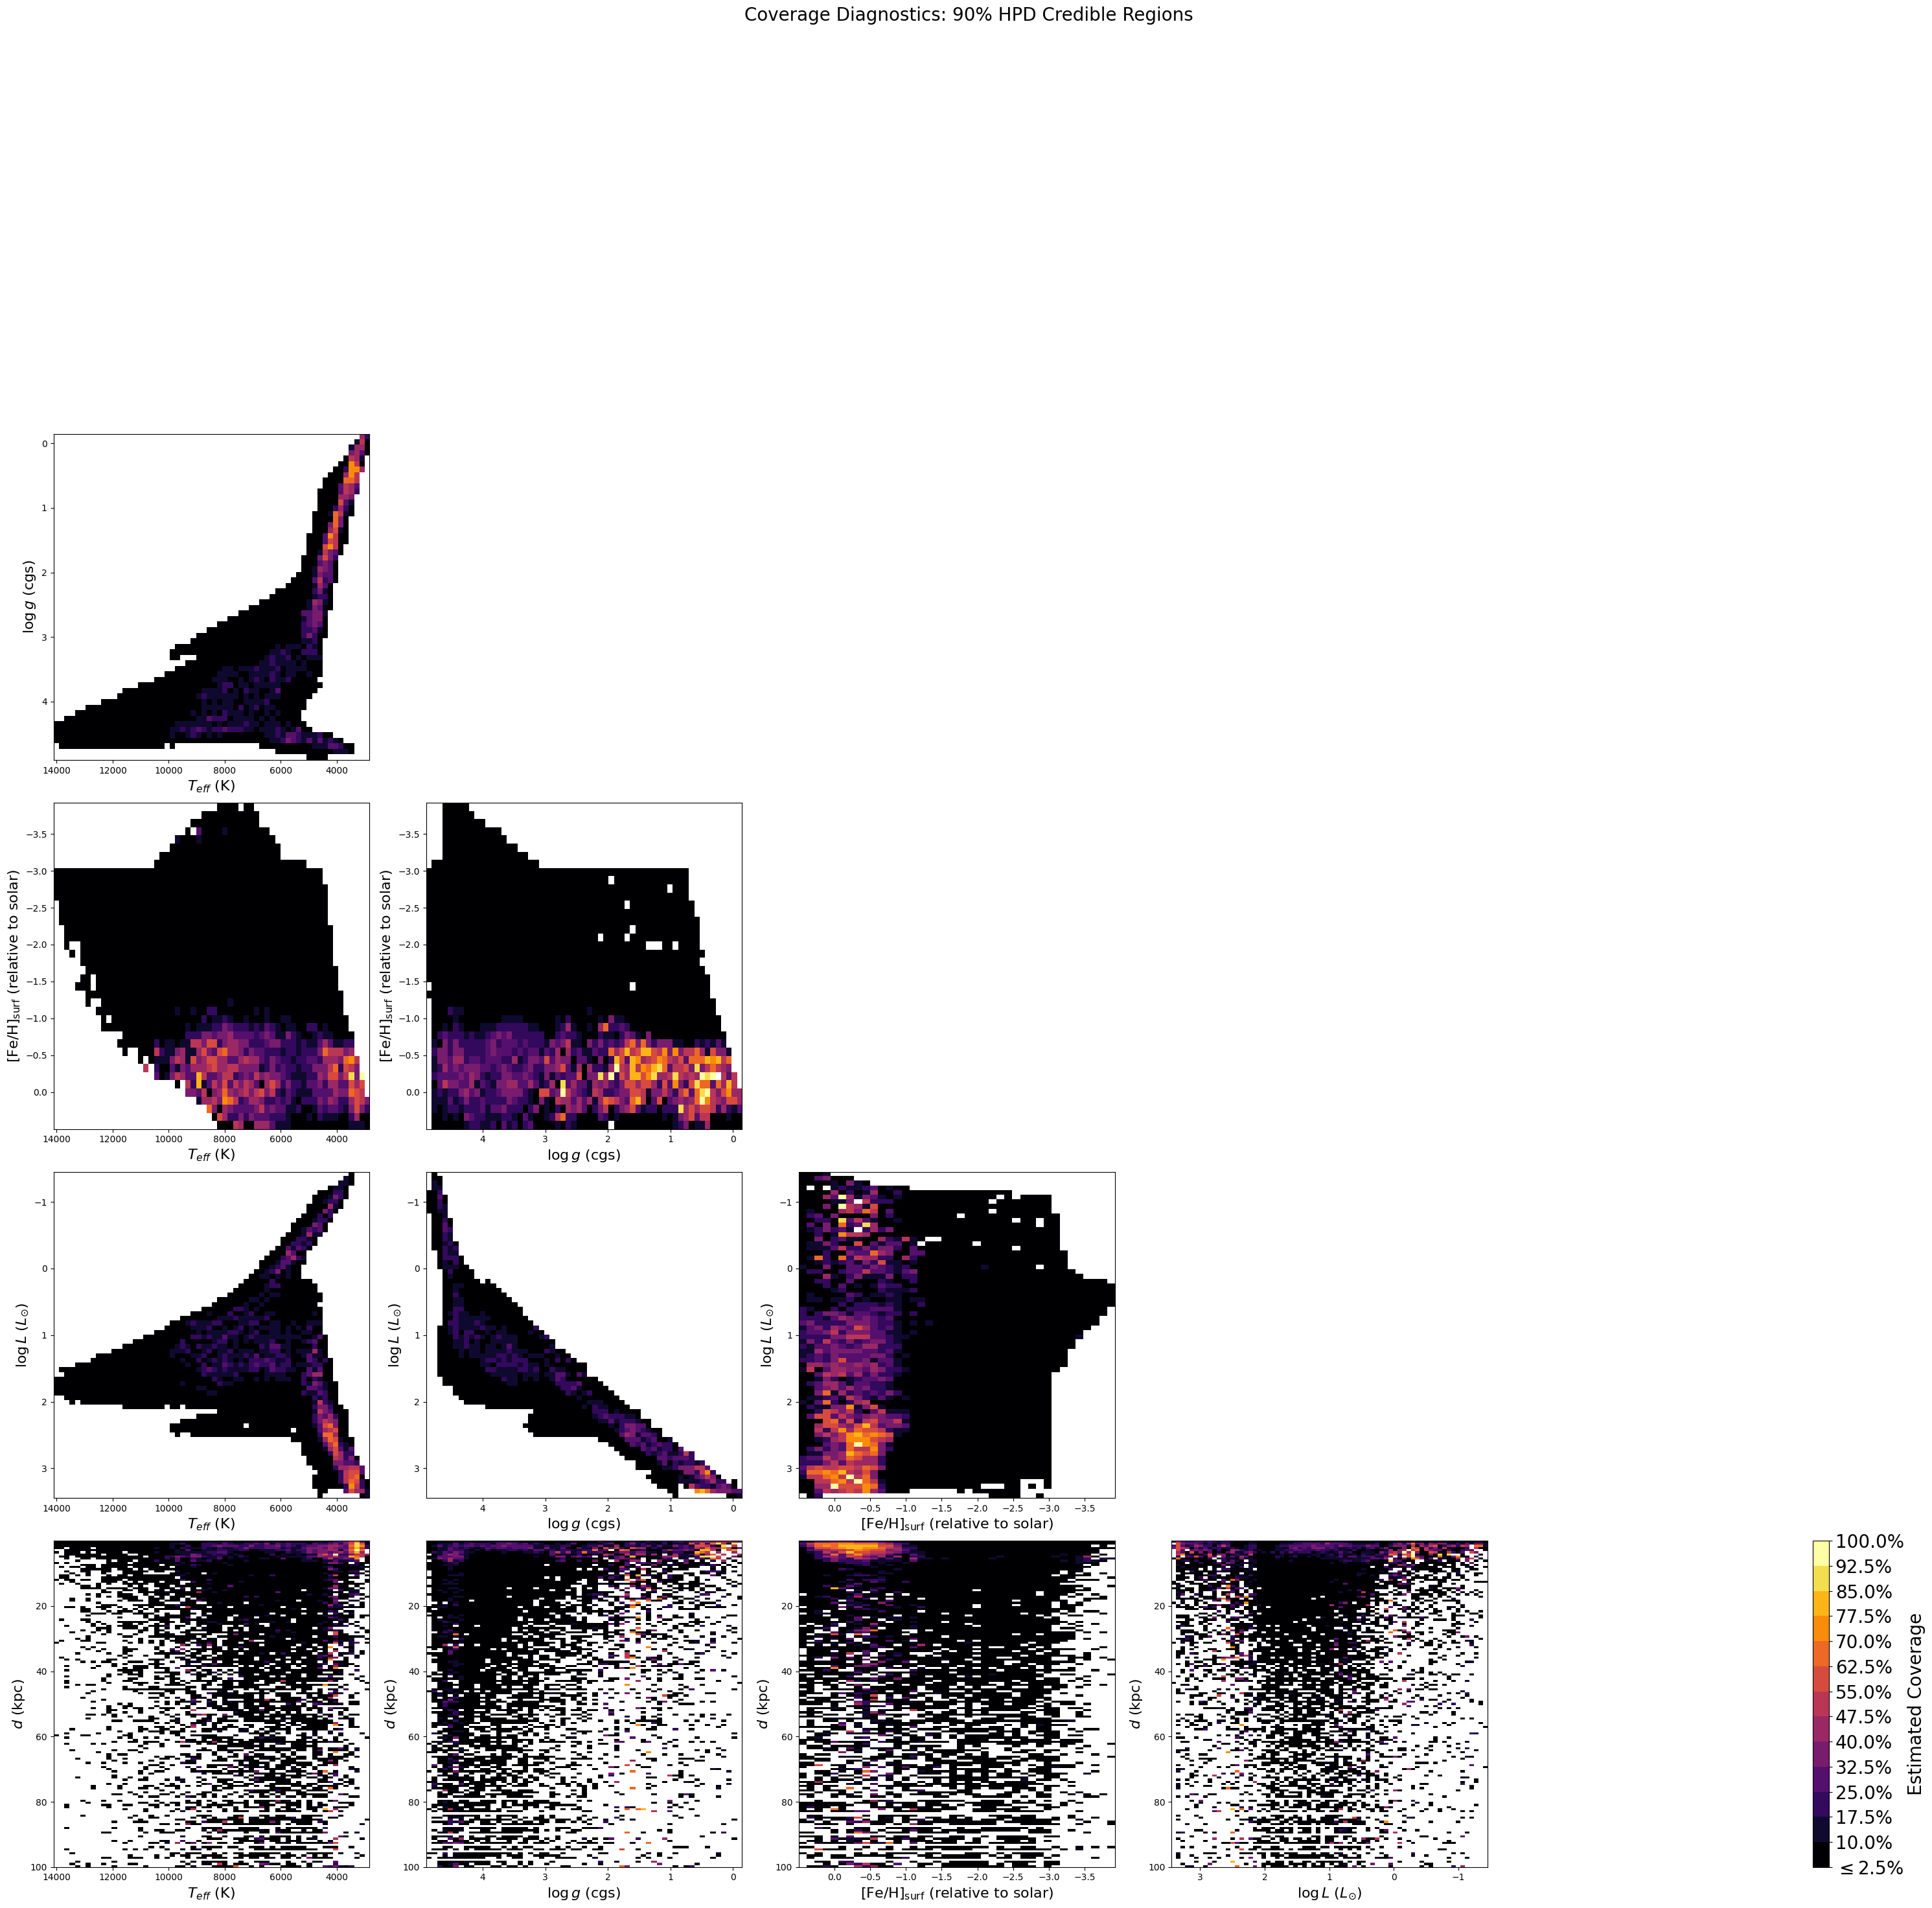

In [41]:
fig = plot_pointwise_coverage_full(diagnostics_estimator_hpd)
plt.savefig(f'{example_dir_for_setting}/pointwise_coverage_hpd.png', dpi=500)
plt.show()
plt.close()

/tmp/user/3391/ipykernel_2161590/3421426924.py:40: RuntimeWarning: invalid value encountered in divide
  heatmap_values = binned_sum_proba / bin_counts


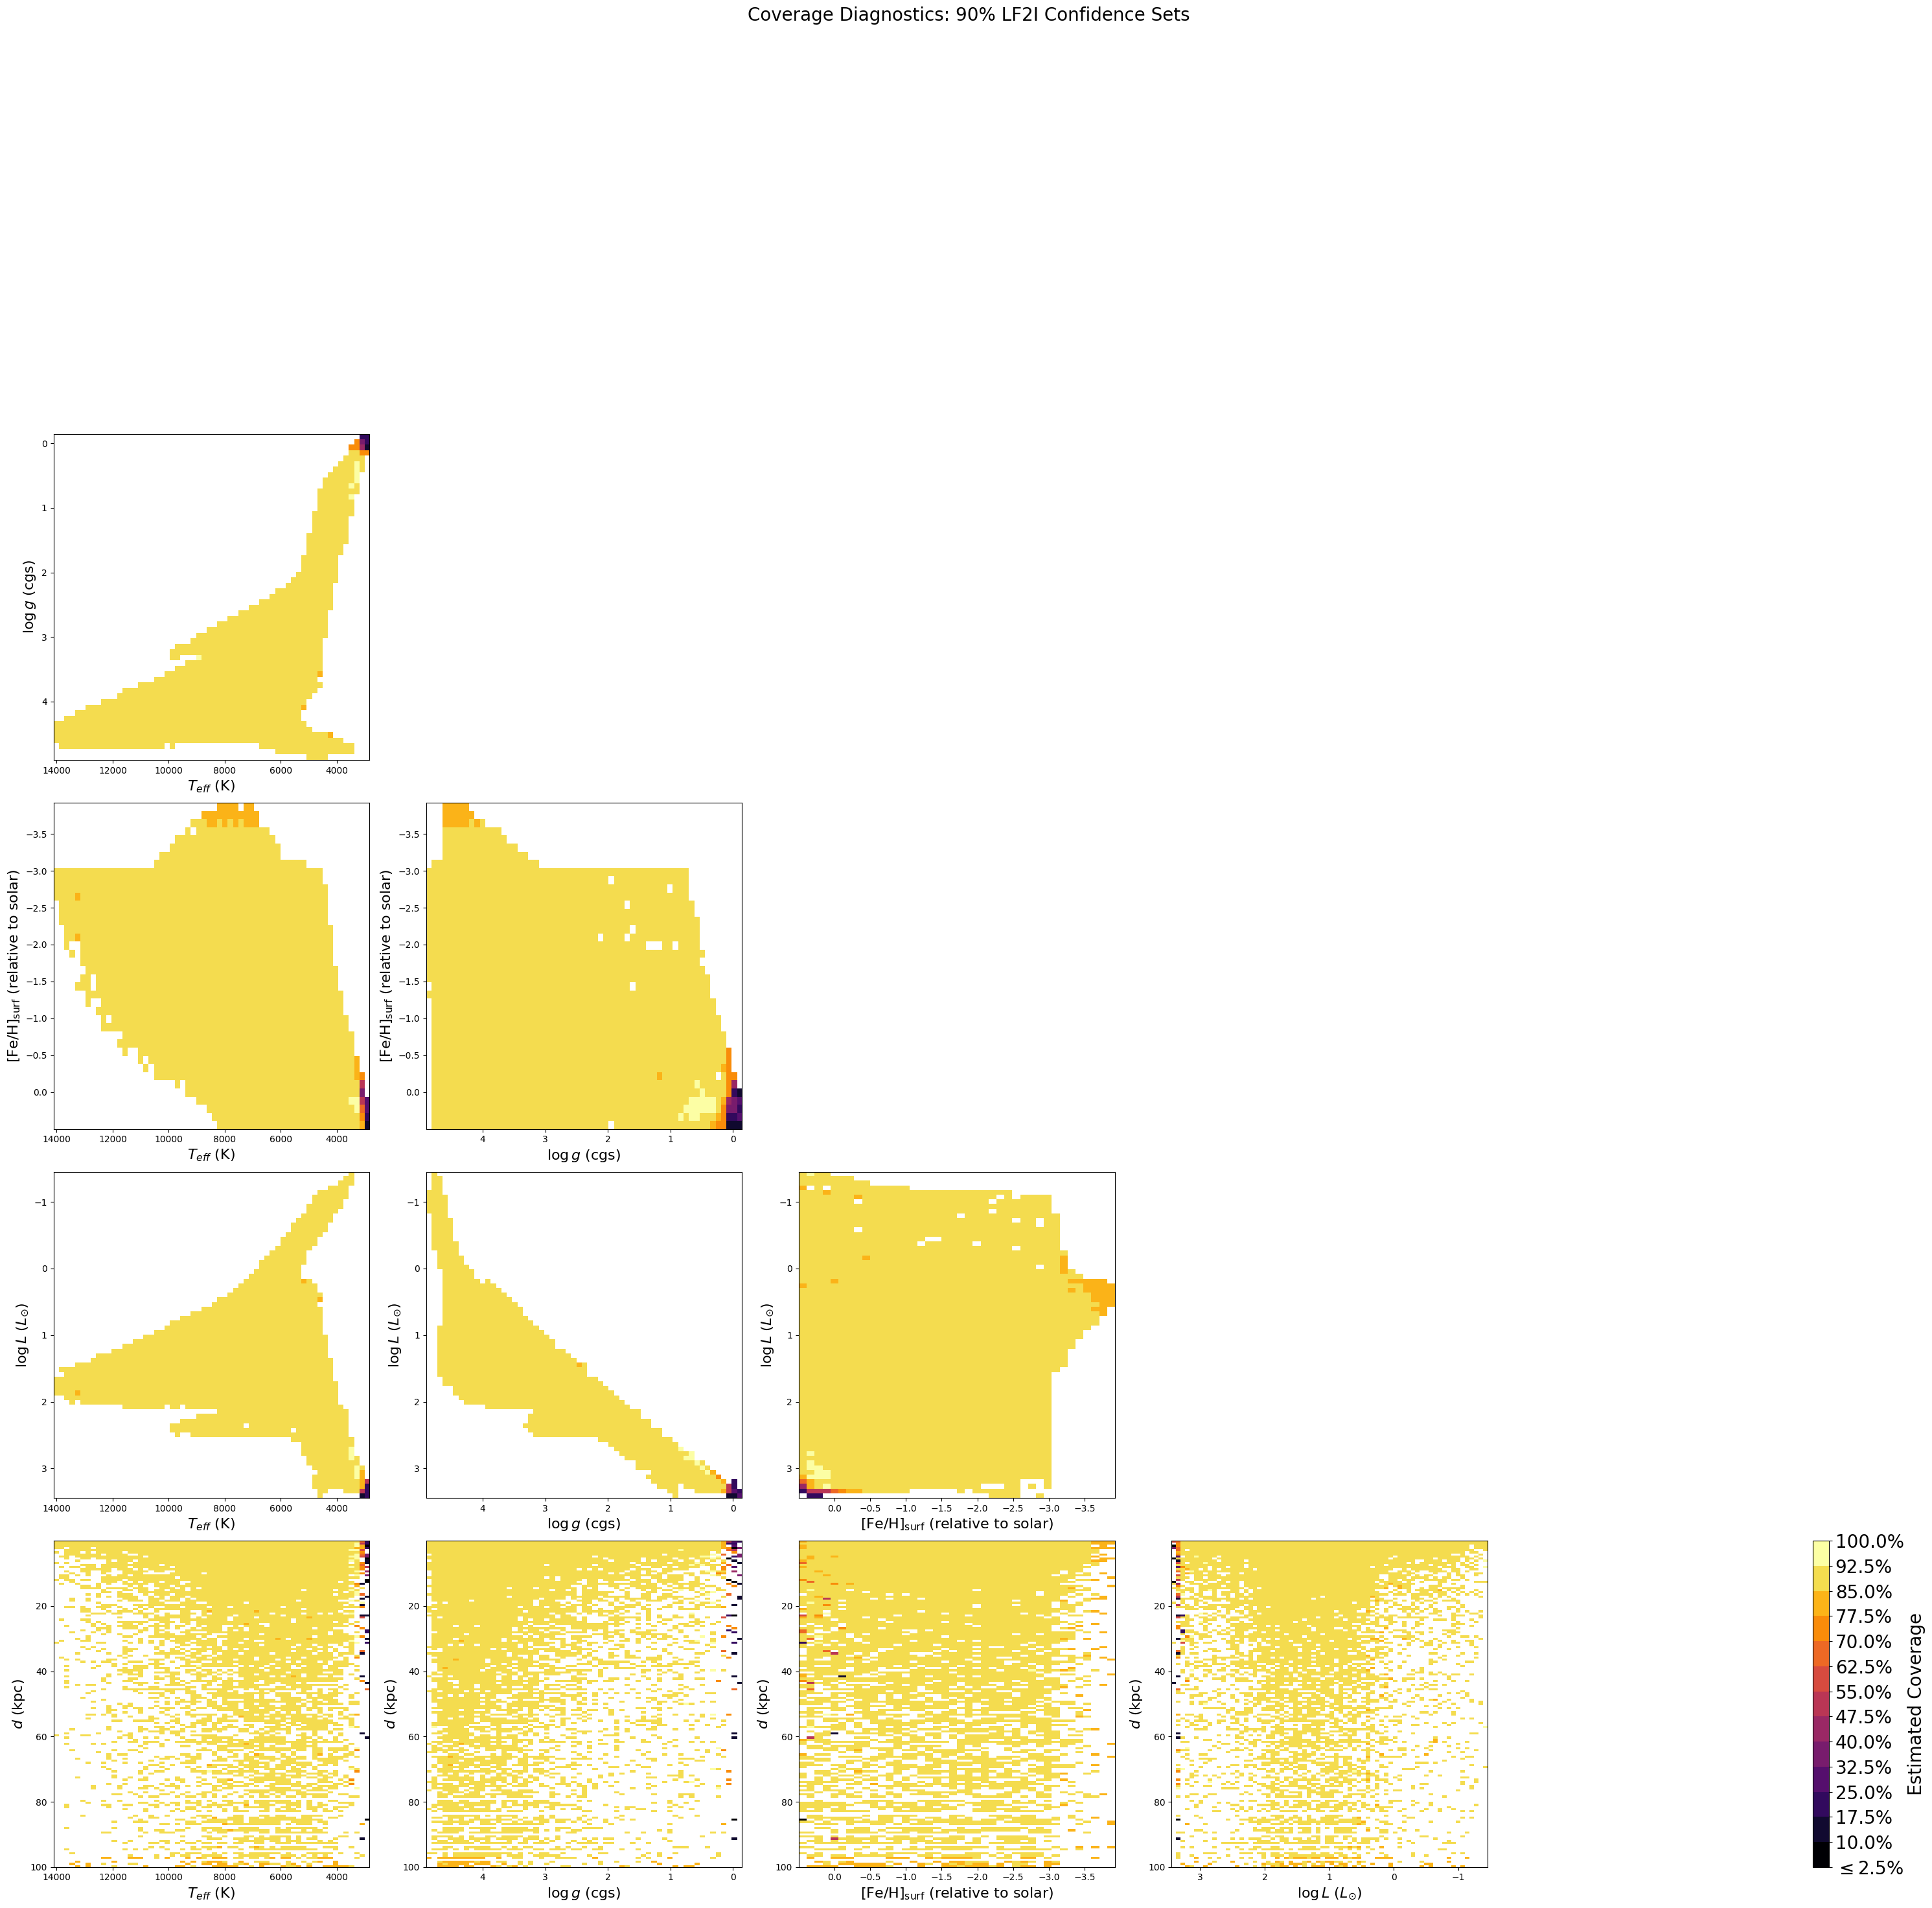

In [42]:
fig = plot_pointwise_coverage_full(diagnostics_estimator_lf2i, title="Coverage Diagnostics: 90% LF2I Confidence Sets")
plt.savefig(f'{example_dir_for_setting}/pointwise_coverage_lf2i.png', dpi=500)
plt.show()
plt.close()